In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 31 kB/s 
     |████████████████████████████████| 198 kB 38.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=2a04e8e62b9e64c6201340d28ce2e06269deb83988f19bb4b3b3cfd579c6a971
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import *

app_name = 'final_project'

conf = SparkConf()

hdfs_host = 'hdfs://namenode:8020'

conf.set("hive.metastore.uris", "http://hive-metastore:9083")
conf.set("spark.kerberos.access.hadoopFileSystem", hdfs_host)
conf.set("spark.sql.warehouse.dir", f"{hdfs_host}/user/hive/warehouse")
conf.set("hive.metastore.warehouse.dir", f"{hdfs_host}/user/hive/warehouse")

spark = SparkSession\
  .builder\
  .appName(app_name)\
  .config(conf=conf)\
  .getOrCreate()

In [3]:
movies_meta = spark\
  .read\
  .option("multiLine", "true")\
  .option("quote", '"')\
  .option("header", "true")\
  .option("escape", '"')\
  .option("wholeFile", True)\
  .csv("movies_metadata.csv", header=True)\

movies_meta = movies_meta\
  .where("imdb_id not in ('0', 'tt0113002', 'tt2423504', 'tt2622826')")

movies = movies_meta\
  .withColumn('imdb_id', f.col('imdb_id').substr(3, 100))\
  .select('id', 'title', 'imdb_id', 'original_title', 'overview', 'homepage', 'popularity', 
          'release_date', 'revenue', 'runtime', 'status')

# # recalculate vote_count and vote_average and join them with movies

# ratings = spark\
#         .read\
#         .option('inferSchema', 'true')\
#         .option("wholeFile", True)\
#         .csv("ratings.csv", header=True)\
#         .drop('timestamp', 'userId')
        
        
# ratings = ratings.groupBy('movieId')\
#                  .agg(f.count('*').alias('vote_count'),\
#                       f.avg('rating').cast('decimal(10, 1)').alias('vote_average'))\

# movies = movies\
#                 .join(ratings, f.col('id') == f.col('movieId'), 'left')\
#                 .drop(f.col('movieId'))\

movies.show()

+-----+--------------------+-------+--------------------+--------------------+--------------------+----------+------------+---------+-------+--------+
|   id|               title|imdb_id|      original_title|            overview|            homepage|popularity|release_date|  revenue|runtime|  status|
+-----+--------------------+-------+--------------------+--------------------+--------------------+----------+------------+---------+-------+--------+
|  862|           Toy Story|0114709|           Toy Story|Led by Woody, And...|http://toystory.d...| 21.946943|  1995-10-30|373554033|   81.0|Released|
| 8844|             Jumanji|0113497|             Jumanji|When siblings Jud...|                null| 17.015539|  1995-12-15|262797249|  104.0|Released|
|15602|    Grumpier Old Men|0113228|    Grumpier Old Men|A family wedding ...|                null|   11.7129|  1995-12-22|        0|  101.0|Released|
|31357|   Waiting to Exhale|0114885|   Waiting to Exhale|Cheated on, mistr...|                

In [4]:
keywords = spark\
          .read\
          .option("multiLine", "true")\
          .option("quote", '"')\
          .option("header", "true")\
          .option("escape", '"')\
          .option("wholeFile", True)\
          .csv("keywords.csv", header=True)

keywords_schema = ArrayType(StructType([StructField('id',IntegerType(),True),
                        StructField('name',StringType(),True)]))

keywords = keywords\
          .withColumn('keyword', f.from_json(f.col('keywords'), keywords_schema))\
          .withColumn('keyword', f.explode(f.col("keyword.name")))\
          .withColumnRenamed('id', 'movie_id')\
          .withColumn('keyword_business_key', f.monotonically_increasing_id())\
          .select('keyword_business_key', 'keyword', 'movie_id')

keywords.show()


+--------------------+--------------------+--------+
|keyword_business_key|             keyword|movie_id|
+--------------------+--------------------+--------+
|                   0|            jealousy|     862|
|                   1|                 toy|     862|
|                   2|                 boy|     862|
|                   3|          friendship|     862|
|                   4|             friends|     862|
|                   5|             rivalry|     862|
|                   6|       boy next door|     862|
|                   7|             new toy|     862|
|                   8|   toy comes to life|     862|
|                   9|          board game|    8844|
|                  10|       disappearance|    8844|
|                  11|based on children...|    8844|
|                  12|            new home|    8844|
|                  13|             recluse|    8844|
|                  14|        giant insect|    8844|
|                  15|             fishing|   

In [5]:
genre_schema = ArrayType(StructType([StructField('name',StringType(),True)]))

genres = movies_meta\
      .withColumn('genres', f.regexp_replace(f.col('genres'), ': None', ': null'))\
      .withColumn('genres', f.regexp_replace(f.col('genres'), "\\\\'", ""))\
      .withColumn('genres', f.regexp_replace(f.col('genres'), "\\\\", ""))\
      .withColumnRenamed('id', 'movie_id')\
      .select('movie_id', 'genres')

genres = genres\
  .withColumn('genres', f.from_json(genres.genres, genre_schema))

# genres.show()

genres = genres\
  .withColumn('genre', f.explode('genres'))\
  .select('movie_id','genre.name')

# genres.show(20, vertical=False, truncate=False)

genres = genres\
    .withColumn('genre_business_key', f.monotonically_increasing_id())\
    .withColumnRenamed('name', 'genre')\
    .select('genre_business_key', 'genre', 'movie_id')

genres.show()

+------------------+---------+--------+
|genre_business_key|    genre|movie_id|
+------------------+---------+--------+
|                 0|Animation|     862|
|                 1|   Comedy|     862|
|                 2|   Family|     862|
|                 3|Adventure|    8844|
|                 4|  Fantasy|    8844|
|                 5|   Family|    8844|
|                 6|  Romance|   15602|
|                 7|   Comedy|   15602|
|                 8|   Comedy|   31357|
|                 9|    Drama|   31357|
|                10|  Romance|   31357|
|                11|   Comedy|   11862|
|                12|   Action|     949|
|                13|    Crime|     949|
|                14|    Drama|     949|
|                15| Thriller|     949|
|                16|   Comedy|   11860|
|                17|  Romance|   11860|
|                18|   Action|   45325|
|                19|Adventure|   45325|
+------------------+---------+--------+
only showing top 20 rows



In [6]:
language_schema = ArrayType(StructType([StructField('name',StringType(),True)]))

languages = movies_meta\
      .withColumn('spoken_languages', f.regexp_replace(f.col('spoken_languages'), ': None', ': null'))\
      .withColumn('spoken_languages', f.regexp_replace(f.col('spoken_languages'), "\\\\'", ""))\
      .withColumn('spoken_languages', f.regexp_replace(f.col('spoken_languages'), "\\\\", ""))\
      .withColumnRenamed('id', 'movie_id')\
      .withColumnRenamed('spoken_languages', 'languages')\
      .select('movie_id', 'languages')

languages = languages\
  .withColumn('languages', f.from_json(languages.languages, language_schema))

# languages.show()

languages = languages\
  .withColumn('languages', f.explode('languages'))\
  .select('movie_id', 'languages.name')

# languages.show(20, vertical=False, truncate=False)

languages = languages\
    .withColumn('language_business_key', f.monotonically_increasing_id())\
    .withColumnRenamed('name', 'language')\
    .select('language_business_key', 'language', 'movie_id')

languages.show()

+---------------------+--------+--------+
|language_business_key|language|movie_id|
+---------------------+--------+--------+
|                    0| English|     862|
|                    1| English|    8844|
|                    2|Français|    8844|
|                    3| English|   15602|
|                    4| English|   31357|
|                    5| English|   11862|
|                    6| English|     949|
|                    7| Español|     949|
|                    8|Français|   11860|
|                    9| English|   11860|
|                   10| English|   45325|
|                   11| Deutsch|   45325|
|                   12| English|    9091|
|                   13| English|     710|
|                   14| Pусский|     710|
|                   15| Español|     710|
|                   16| English|    9087|
|                   17| English|   12110|
|                   18| Deutsch|   12110|
|                   19| English|   21032|
+---------------------+--------+--

In [7]:
companies_schema = ArrayType(StructType([StructField('name',StringType(),True)]))

production_companies = movies_meta\
    .withColumn('company', f.from_json(f.col('production_companies'), companies_schema))\
    .withColumn("company", f.explode('company.name'))\
    .withColumn('prod_company_business_key', f.monotonically_increasing_id())\
    .withColumnRenamed('id', 'movie_id')\
    .select('prod_company_business_key', 'company', 'movie_id')

production_companies.show()

+-------------------------+--------------------+--------+
|prod_company_business_key|             company|movie_id|
+-------------------------+--------------------+--------+
|                        0|Pixar Animation S...|     862|
|                        1|    TriStar Pictures|    8844|
|                        2|        Teitler Film|    8844|
|                        3|Interscope Commun...|    8844|
|                        4|        Warner Bros.|   15602|
|                        5|      Lancaster Gate|   15602|
|                        6|Twentieth Century...|   31357|
|                        7|Sandollar Product...|   11862|
|                        8| Touchstone Pictures|   11862|
|                        9| Regency Enterprises|     949|
|                       10|        Forward Pass|     949|
|                       11|        Warner Bros.|     949|
|                       12|  Paramount Pictures|   11860|
|                       13|Scott Rudin Produ...|   11860|
|             

In [8]:
countries_schema = ArrayType(StructType([StructField('name',StringType(),True)]))

production_countries = movies_meta\
    .withColumn('country', f.from_json(f.col('production_countries'), countries_schema))\
    .withColumn("country", f.explode('country.name'))\
    .withColumn('prod_country_business_key', f.monotonically_increasing_id())\
    .withColumnRenamed('id', 'movie_id')\
    .select('prod_country_business_key','country', 'movie_id')

production_countries.show()

+-------------------------+--------------------+--------+
|prod_country_business_key|             country|movie_id|
+-------------------------+--------------------+--------+
|                        0|United States of ...|     862|
|                        1|United States of ...|    8844|
|                        2|United States of ...|   15602|
|                        3|United States of ...|   31357|
|                        4|United States of ...|   11862|
|                        5|United States of ...|     949|
|                        6|             Germany|   11860|
|                        7|United States of ...|   11860|
|                        8|United States of ...|   45325|
|                        9|United States of ...|    9091|
|                       10|      United Kingdom|     710|
|                       11|United States of ...|     710|
|                       12|United States of ...|    9087|
|                       13|              France|   12110|
|             

In [9]:
cast_schema = ArrayType(
    StructType(
        [
            StructField("id", IntegerType(), True),
            StructField("name", StringType(), True),
        ]
    )
)

creds = (
    spark.read.option("quote", '"')
    .option("escape", '"')
    .csv("credits.csv", header=True)
    .withColumn("cast", f.regexp_replace(f.col("cast"), ": None", ": null"))
    .withColumn("cast", f.regexp_replace(f.col("cast"), "\\\\'", ""))
    .withColumn("cast", f.regexp_replace(f.col("cast"), "\\\\", ""))
    .drop("crew")
)
creds = creds.withColumn("actors", f.from_json(creds.cast, cast_schema))

# creds.show()

actors = (
    creds.withColumn("actor", f.explode("actors"))
    .withColumnRenamed("id", "movie_id")
    .select("movie_id", "actor.name")
)

# actors.show(20, vertical=False, truncate=False)

cast = actors.withColumn("actor_business_key", f.monotonically_increasing_id()).select(
    "actor_business_key", "movie_id", f.col("name").alias("actor_name")
)

cast.show()

+------------------+--------+-----------------+
|actor_business_key|movie_id|       actor_name|
+------------------+--------+-----------------+
|                 0|     862|        Tom Hanks|
|                 1|     862|        Tim Allen|
|                 2|     862|      Don Rickles|
|                 3|     862|       Jim Varney|
|                 4|     862|    Wallace Shawn|
|                 5|     862|John Ratzenberger|
|                 6|     862|      Annie Potts|
|                 7|     862|      John Morris|
|                 8|     862|  Erik von Detten|
|                 9|     862|   Laurie Metcalf|
|                10|     862|     R. Lee Ermey|
|                11|     862|    Sarah Freeman|
|                12|     862|    Penn Jillette|
|                13|    8844|   Robin Williams|
|                14|    8844|    Jonathan Hyde|
|                15|    8844|    Kirsten Dunst|
|                16|    8844|   Bradley Pierce|
|                17|    8844|      Bonni

In [10]:
!pip install imdbpy

     |████████████████████████████████| 298 kB 9.2 MB/s 


In [11]:
from imdb import IMDb

In [18]:
from pyspark.sql import functions as f

movies_ids = movies\
        .limit(10)\
        .select('id', 'imdb_id', 'title')

movies_ids.show()

+-----+-------+--------------------+
|   id|imdb_id|               title|
+-----+-------+--------------------+
|  862|0114709|           Toy Story|
| 8844|0113497|             Jumanji|
|15602|0113228|    Grumpier Old Men|
|31357|0114885|   Waiting to Exhale|
|11862|0113041|Father of the Bri...|
|  949|0113277|                Heat|
|11860|0114319|             Sabrina|
|45325|0112302|        Tom and Huck|
| 9091|0114576|        Sudden Death|
|  710|0113189|           GoldenEye|
+-----+-------+--------------------+



In [19]:
!pip install urllib3

In [20]:
movies_data = movies_ids\
                  .join(genres, f.col('id') == f.col('movie_id'), 'left')\
                  .select('imdb_id', 'title', 'genre')\
                  .where(f.col('genre').isNotNull())

movies_data.show()

+-------+--------------------+---------+
|imdb_id|               title|    genre|
+-------+--------------------+---------+
|0114709|           Toy Story|Animation|
|0114709|           Toy Story|   Comedy|
|0114709|           Toy Story|   Family|
|0113497|             Jumanji|Adventure|
|0113497|             Jumanji|  Fantasy|
|0113497|             Jumanji|   Family|
|0113228|    Grumpier Old Men|  Romance|
|0113228|    Grumpier Old Men|   Comedy|
|0114885|   Waiting to Exhale|   Comedy|
|0114885|   Waiting to Exhale|    Drama|
|0114885|   Waiting to Exhale|  Romance|
|0113041|Father of the Bri...|   Comedy|
|0113277|                Heat|   Action|
|0113277|                Heat|    Crime|
|0113277|                Heat|    Drama|
|0113277|                Heat| Thriller|
|0114319|             Sabrina|   Comedy|
|0114319|             Sabrina|  Romance|
|0112302|        Tom and Huck|   Action|
|0112302|        Tom and Huck|Adventure|
+-------+--------------------+---------+
only showing top

In [21]:
genres_list = [i.genre for i in movies_data.select('genre').distinct().collect()]

genres_list


['Crime',
 'Romance',
 'Thriller',
 'Adventure',
 'Drama',
 'Family',
 'Fantasy',
 'Animation',
 'Comedy',
 'Action']

In [22]:
import os

datasets = ['training', 'test']

for dataset in datasets:
  path = os.path.join(os.getcwd(), dataset)
  if not os.path.exists(path):
    os.mkdir(path)

In [24]:
import requests

def create_dataset_dir(dataset, genre):
  path = os.path.join(os.getcwd(), f"{dataset}/{genre}")
  if not os.path.exists(path):
    os.mkdir(path)

def download_poster(imdb_id, genre, dataset):
  ia = IMDb()

  movie = ia.get_movie(imdb_id)

  res = requests.get(movie['cover url'])
  path = f'{dataset}/{genre}/{imdb_id}.jpg'
  path = os.path.join(os.getcwd(), path)
  file = open(path, 'wb')
  file.write(res.content)
  file.close()

def download_training_posters(genre, training_imdb_ids):
  for i in training_imdb_ids:
    download_poster(i, genre, 'training')

def download_test_posters(genre, test_imdb_ids):
  for i in test_imdb_ids:
    download_poster(i, genre, 'test')

for genre in genres_list:
  genre_movies = movies_data\
                        .select('imdb_id')\
                        .where(f"genre = '{genre}'")

  genre_movies_as_list = [e[0] for e in genre_movies.select('imdb_id').rdd.collect()]

  print(f"{genre}, {genre_movies_as_list}")

  num_genres = len(genre_movies_as_list)

  create_dataset_dir("training", genre)
  create_dataset_dir("test", genre)

  test_data = genre_movies_as_list[0:((int)(num_genres/5))]
  training_data = genre_movies_as_list[((int)(num_genres/5)):]

  download_training_posters(genre, training_data)
  download_test_posters(genre, test_data)

Crime, ['0113277']
Romance, ['0113228', '0114885', '0114319']
Thriller, ['0113277', '0114576', '0113189']
Adventure, ['0113497', '0112302', '0114576', '0113189']
Drama, ['0114885', '0113277', '0112302']
Family, ['0114709', '0113497', '0112302']
Fantasy, ['0113497']
Animation, ['0114709']
Comedy, ['0114709', '0113228', '0114885', '0113041', '0114319']
Action, ['0113277', '0112302', '0114576', '0113189']


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np

In [26]:
labels = genres_list
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [27]:
train = get_data('training')
val = get_data('test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


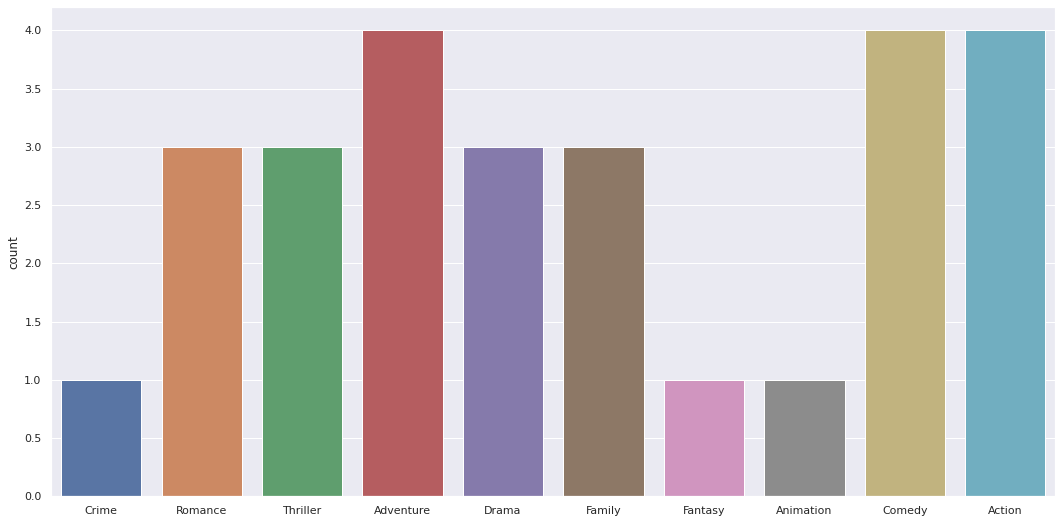

In [28]:
l = []
for i in train:
  for index in range(len(labels)):
    if(i[1] == index):
      l.append(labels[index])

sns.set(rc={'figure.figsize':(18,9)})
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'Crime')

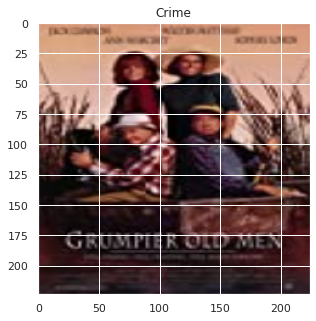

In [29]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'Action')

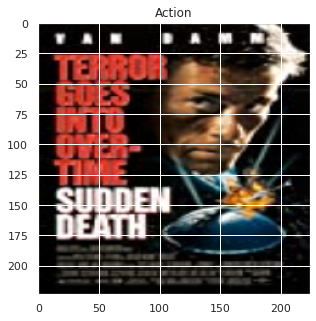

In [30]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [31]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [32]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [33]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(len(labels), activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [34]:
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
history = model.fit(x_train,y_train,epochs = 20 , validation_data = (x_val, y_val))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 3s 3s/step - loss: 2.2837 - accuracy: 0.1111 - val_loss: 2.2535 - val_accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 2.2995 - accuracy: 0.1481 - val_loss: 2.2516 - val_accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 2.3041 - accuracy: 0.0741 - val_loss: 2.2498 - val_accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 2.2939 - accuracy: 0.1481 - val_loss: 2.2479 - val_accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 2.2971 - accuracy: 0.0370 - val_loss: 2.2460 - val_accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 2.3005 - accuracy: 0.1111 - val_loss: 2.2441 - val_accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 2.2957 - accuracy: 0.0741 - val_loss: 2.2422 - val_accuracy: 0.0000e+00
Epoch 8/20
1/1 [========